# Дослідження набору даних

In [1]:
import pandas as pd

df = pd.read_csv("Datasets/train_car_demand.csv")
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [2]:
df.drop(['date', 'hour'], axis=1, inplace=True)
df.head()

,demand
0,91
1,21
2,23
3,104
4,81


<Axes: >

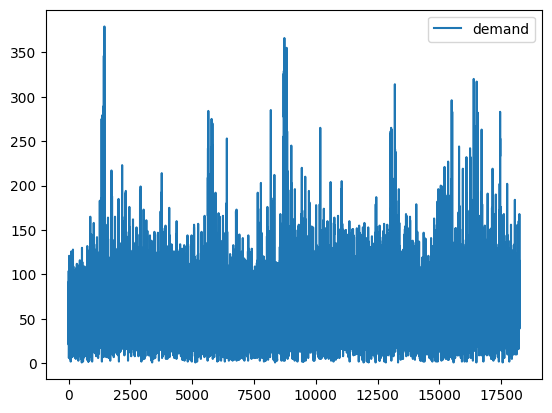

In [3]:
import matplotlib.pyplot as plt

df.plot()

<Axes: >

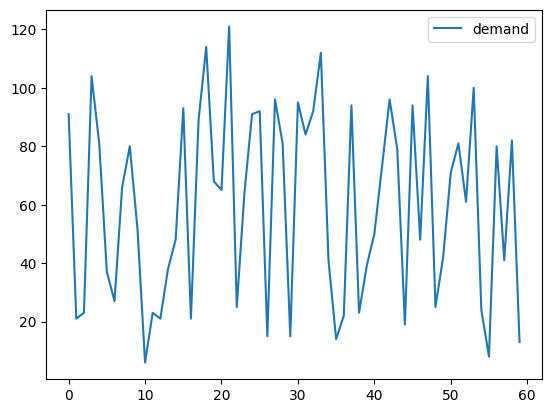

In [4]:
df_sliced = df.iloc[0:60]

df_sliced.plot()

# Перевіримо, чи часові ряди стаціонарні

## Метод №1: Побудова графіку часових рядів

Як видно з графіків, які були побудовані під час дослідження набору даних, тренди в них визначити важко.

## Метод №2: графіки функції автокореляції (ACF) та часткової функції автокореляції (PACF)

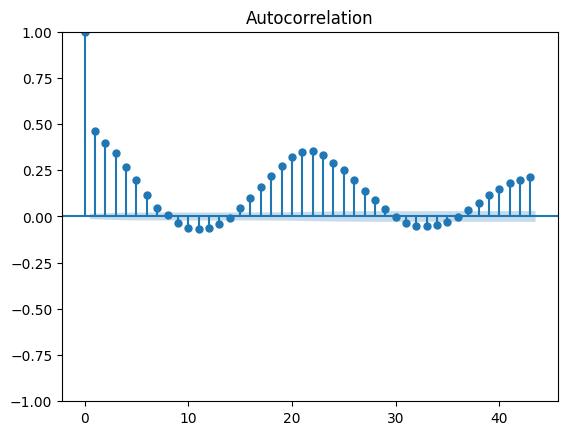

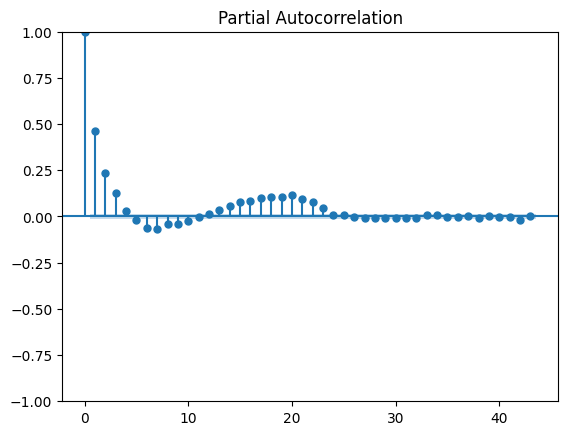

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(df)
pacf_plot = plot_pacf(df)

## Метод №3: ADF тест

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df)
print(f"p-value: {adf_test[1]}")

p-value: 2.285775462202281e-23


# Fit ARIMA model

In [7]:
n = 1000  # залишимо останні 1000 точок на тест
train = df[:-1000]
test = df[-1000:]

In [8]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                17247
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -86142.129
Date:                Fri, 11 Apr 2025   AIC                         172294.257
Time:                        23:19:56   BIC                         172333.034
Sample:                             0   HQIC                        172307.036
                              - 17247                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.7702      0.809     91.222      0.000      72.185      75.355
ar.L1          0.7930      0.008     95.644      0.000       0.777       0.809
ma.L1         -0.4780      0.011    -43.245      0.0

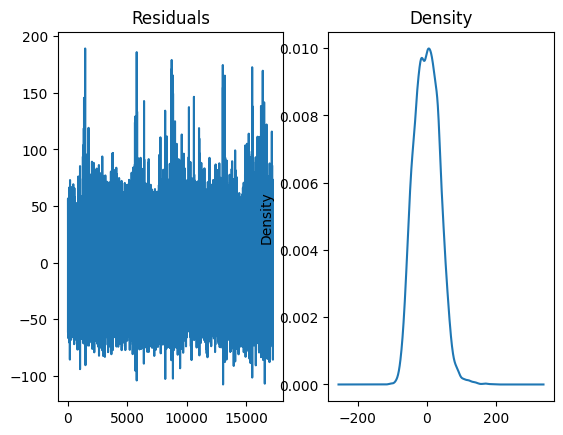

In [9]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde' , ax=ax[1])
plt.show()

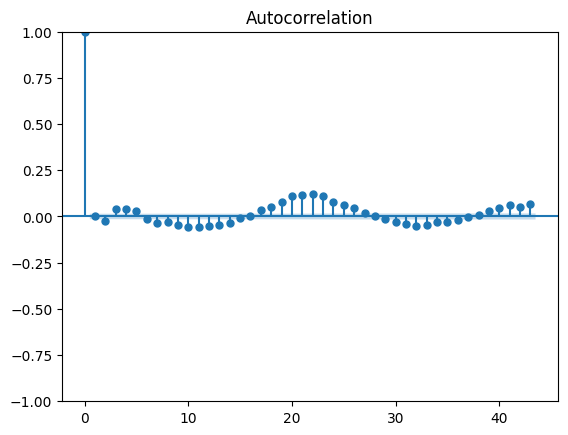

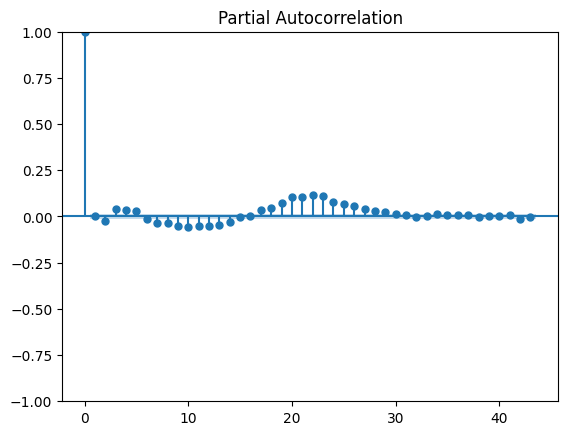

In [10]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: >

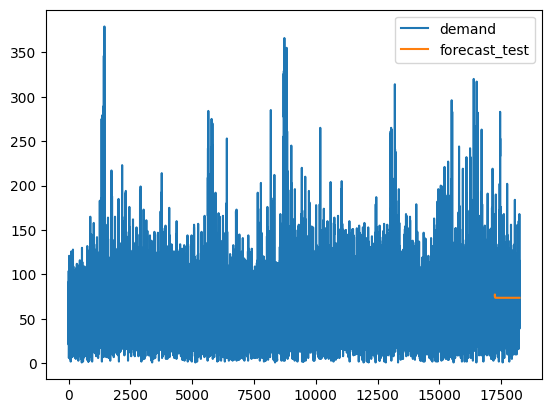

In [11]:
forecast_test = model_fit.forecast(len(test))
df['forecast_test'] = [None]*len(train) + list(forecast_test)

df.plot()

In [12]:
import pmdarima as pm
auto_arima = pm.auto_arima(df['demand'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True)

In [13]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18247
Model:               SARIMAX(1, 1, 4)   Log Likelihood              -90999.170
Date:                Fri, 11 Apr 2025   AIC                         182012.341
Time:                        23:21:12   BIC                         182067.023
Sample:                             0   HQIC                        182030.311
                              - 18247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.166      0.868      -0.004       0.005
ar.L1          0.6868      0.015     45.265      0.000       0.657       0.717
ma.L1         -1.3822      0.016    -84.476      0.000      -1.414      -1.350
ma.L2          0.4430      0.016     27.063      0.000       0.411       0.475
ma.L3          0.0341      0.013      2.701      0.007       0.009       0.059
ma.L4         -0.0869      0.009     -9.572      0.000      -0.105      -0.069
sigma2      1257.0604     13.557     92.727      0.000    1230.490    1283.631
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               167.35
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

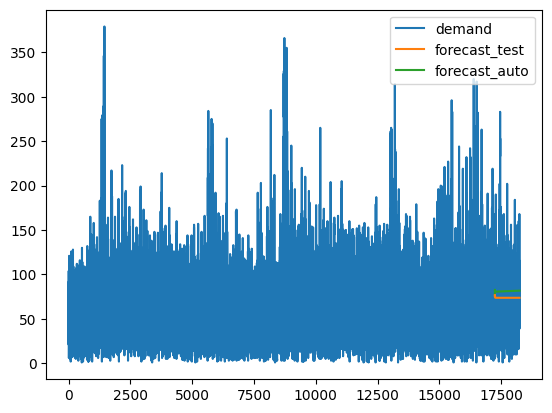

In [14]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

df.plot()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 30.863036218964073
mape - manual: 0.7980852962953586
rmse - manual: 38.82537588737813


In [16]:
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 30.997108673808373
mape - auto: 0.8798967643679994
rmse - auto: 38.792853629598575
